# Importing Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Importing and Normalizing the Salmon Viability Data

In [2]:
# import the salmon survival rate data from Perry et al (2021)
Sal_viab = pd.read_excel('Data/Perry et al 2021 PLoS ONE S2_Table.xlsx', sheet_name=5)

Sal_viab = Sal_viab.rename(columns={'Ocean Entry Year':'Year'})

In [3]:
# normalize salmon data

# take logit of Sal_viab values, because these are proportions in (0,1)
# this is done in the Perry et al paper too
from scipy.special import logit, expit

Sal_viab_logit = logit(Sal_viab).interpolate()
Sal_viab_nrm = (Sal_viab_logit-np.mean(Sal_viab_logit,axis = 0))/np.std(Sal_viab_logit,axis = 0)

# Exploratory Data Analysis via seaborn.pairplot

In [4]:
import seaborn as sns

## Fraser River Water Quality vs Salmon Viability

We have some water quality data, which has far too many variables to compare visually.  Let's import this data and use this to motivate using lasso feature selection.

In [5]:
# importing the Fraser river water quality csv, cleaned to have yearly average values
Fraser_water_qual = pd.read_csv('Data/Fraser_water_qual.csv')
Fraser_water_qual.tail()

,Time,ALKALINITY TOTAL CACO3,ALUMINUM TOTAL,BARIUM EXTRACTABLE,BARIUM TOTAL,BERYLLIUM EXTRACTABLE,BERYLLIUM TOTAL,BORON EXTRACTABLE,CADMIUM EXTRACTABLE,CADMIUM TOTAL,...,CYANIDE WEAK ACID DISSOCIABLE,BICARBONATE (CALCD.),CARBONATE (CALCD.),ORGANIC HALIDES (AOX) - ADSORBABLE,COLOUR TOTAL ABSORBANCE,HYDROXIDE (CALCD.),COLIFORMS TOTAL,BROMINE EXTRACTABLE,BROMIDE,GRAN ALKALINITY (AS H+)
19,2019,53.825749,526.916786,NaN,19.689179,NaN,0.015761,NaN,NaN,0.014957,...,0.005000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05,NaN
20,2020,56.795349,250.873973,NaN,17.409178,NaN,0.009603,NaN,NaN,0.012973,...,0.005000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05,NaN
21,2021,55.452381,709.752174,NaN,20.863623,NaN,0.023401,NaN,NaN,0.017705,...,0.005278,NaN,NaN,NaN,NaN,NaN,3200.0,NaN,0.05,NaN
22,2022,54.711852,670.697021,NaN,21.062669,NaN,0.022576,NaN,NaN,0.025597,...,0.005000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05,NaN
23,2023,56.763636,885.372868,NaN,25.528295,NaN,0.029597,NaN,NaN,0.024760,...,0.005238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05,NaN


There are 222 variables here, so too many really to inspect visually, but we'll look at a few.

In [6]:
# the "extractable" variables have very limited years of data, so let's remove them right away
Fraser_drop = Fraser_water_qual

for var in Fraser_water_qual.columns[1:]:
    if 'EXTRACTABLE' in var:
        Fraser_drop = Fraser_drop.drop(columns=[var])

Fraser_drop.head()

,Time,ALKALINITY TOTAL CACO3,ALUMINUM TOTAL,BARIUM TOTAL,BERYLLIUM TOTAL,CADMIUM TOTAL,CARBON DISSOLVED INORGANIC,CARBON DISSOLVED ORGANIC,CHLORIDE DISSOLVED,CHROMIUM TOTAL,...,CYANIDE TOTAL,CYANIDE WEAK ACID DISSOCIABLE,BICARBONATE (CALCD.),CARBONATE (CALCD.),ORGANIC HALIDES (AOX) - ADSORBABLE,COLOUR TOTAL ABSORBANCE,HYDROXIDE (CALCD.),COLIFORMS TOTAL,BROMIDE,GRAN ALKALINITY (AS H+)
0,2000,71.322857,0.606259,0.022070,0.054203,0.000188,16.600000,3.592754,1.721207,0.001951,...,NaN,NaN,NaN,NaN,13.685714,13.172414,NaN,NaN,NaN,NaN
1,2001,60.568966,0.622333,0.021149,0.056541,0.000188,17.241509,3.064151,1.192481,0.001721,...,NaN,NaN,NaN,NaN,17.400000,13.936170,NaN,NaN,NaN,NaN
2,2002,82.838298,0.923313,0.025958,0.064540,0.000187,20.863158,3.474545,2.906944,0.002530,...,NaN,NaN,NaN,NaN,8.987368,43.555556,NaN,NaN,NaN,NaN
3,2003,88.102041,584.381263,21.732909,0.025741,0.019156,28.200000,3.365868,3.584000,1.363530,...,0.000500,0.000500,NaN,NaN,0.100000,NaN,NaN,NaN,NaN,NaN
4,2004,59.965714,729.141667,23.478394,0.018203,0.022405,27.752174,3.745833,2.945604,1.879723,...,0.001326,0.000513,NaN,NaN,0.100000,NaN,NaN,1717.222222,NaN,NaN


In [7]:
# normalize the water quality data
Fraser_qual_nrm = (Fraser_drop-np.nanmean(Fraser_drop,axis = 0))/np.nanstd(Fraser_drop,axis = 0)

# grab the years overlapping with salmon data
Sal_viab_nrm_2000 = Sal_viab_nrm.iloc[10:28]
Fraser_qual_nrm_2000 = Fraser_qual_nrm.iloc[0:18]

# alternatively, we can restrict the years here to do a train/test split
# Sal_viab_nrm_2000 = Sal_viab_nrm.iloc[10:26] # up to 2015
# Fraser_qual_nrm_2000 = Fraser_qual_nrm.iloc[0:16] # up to 2015

/opt/homebrew/Caskroom/miniforge/base/envs/firstenvironment/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


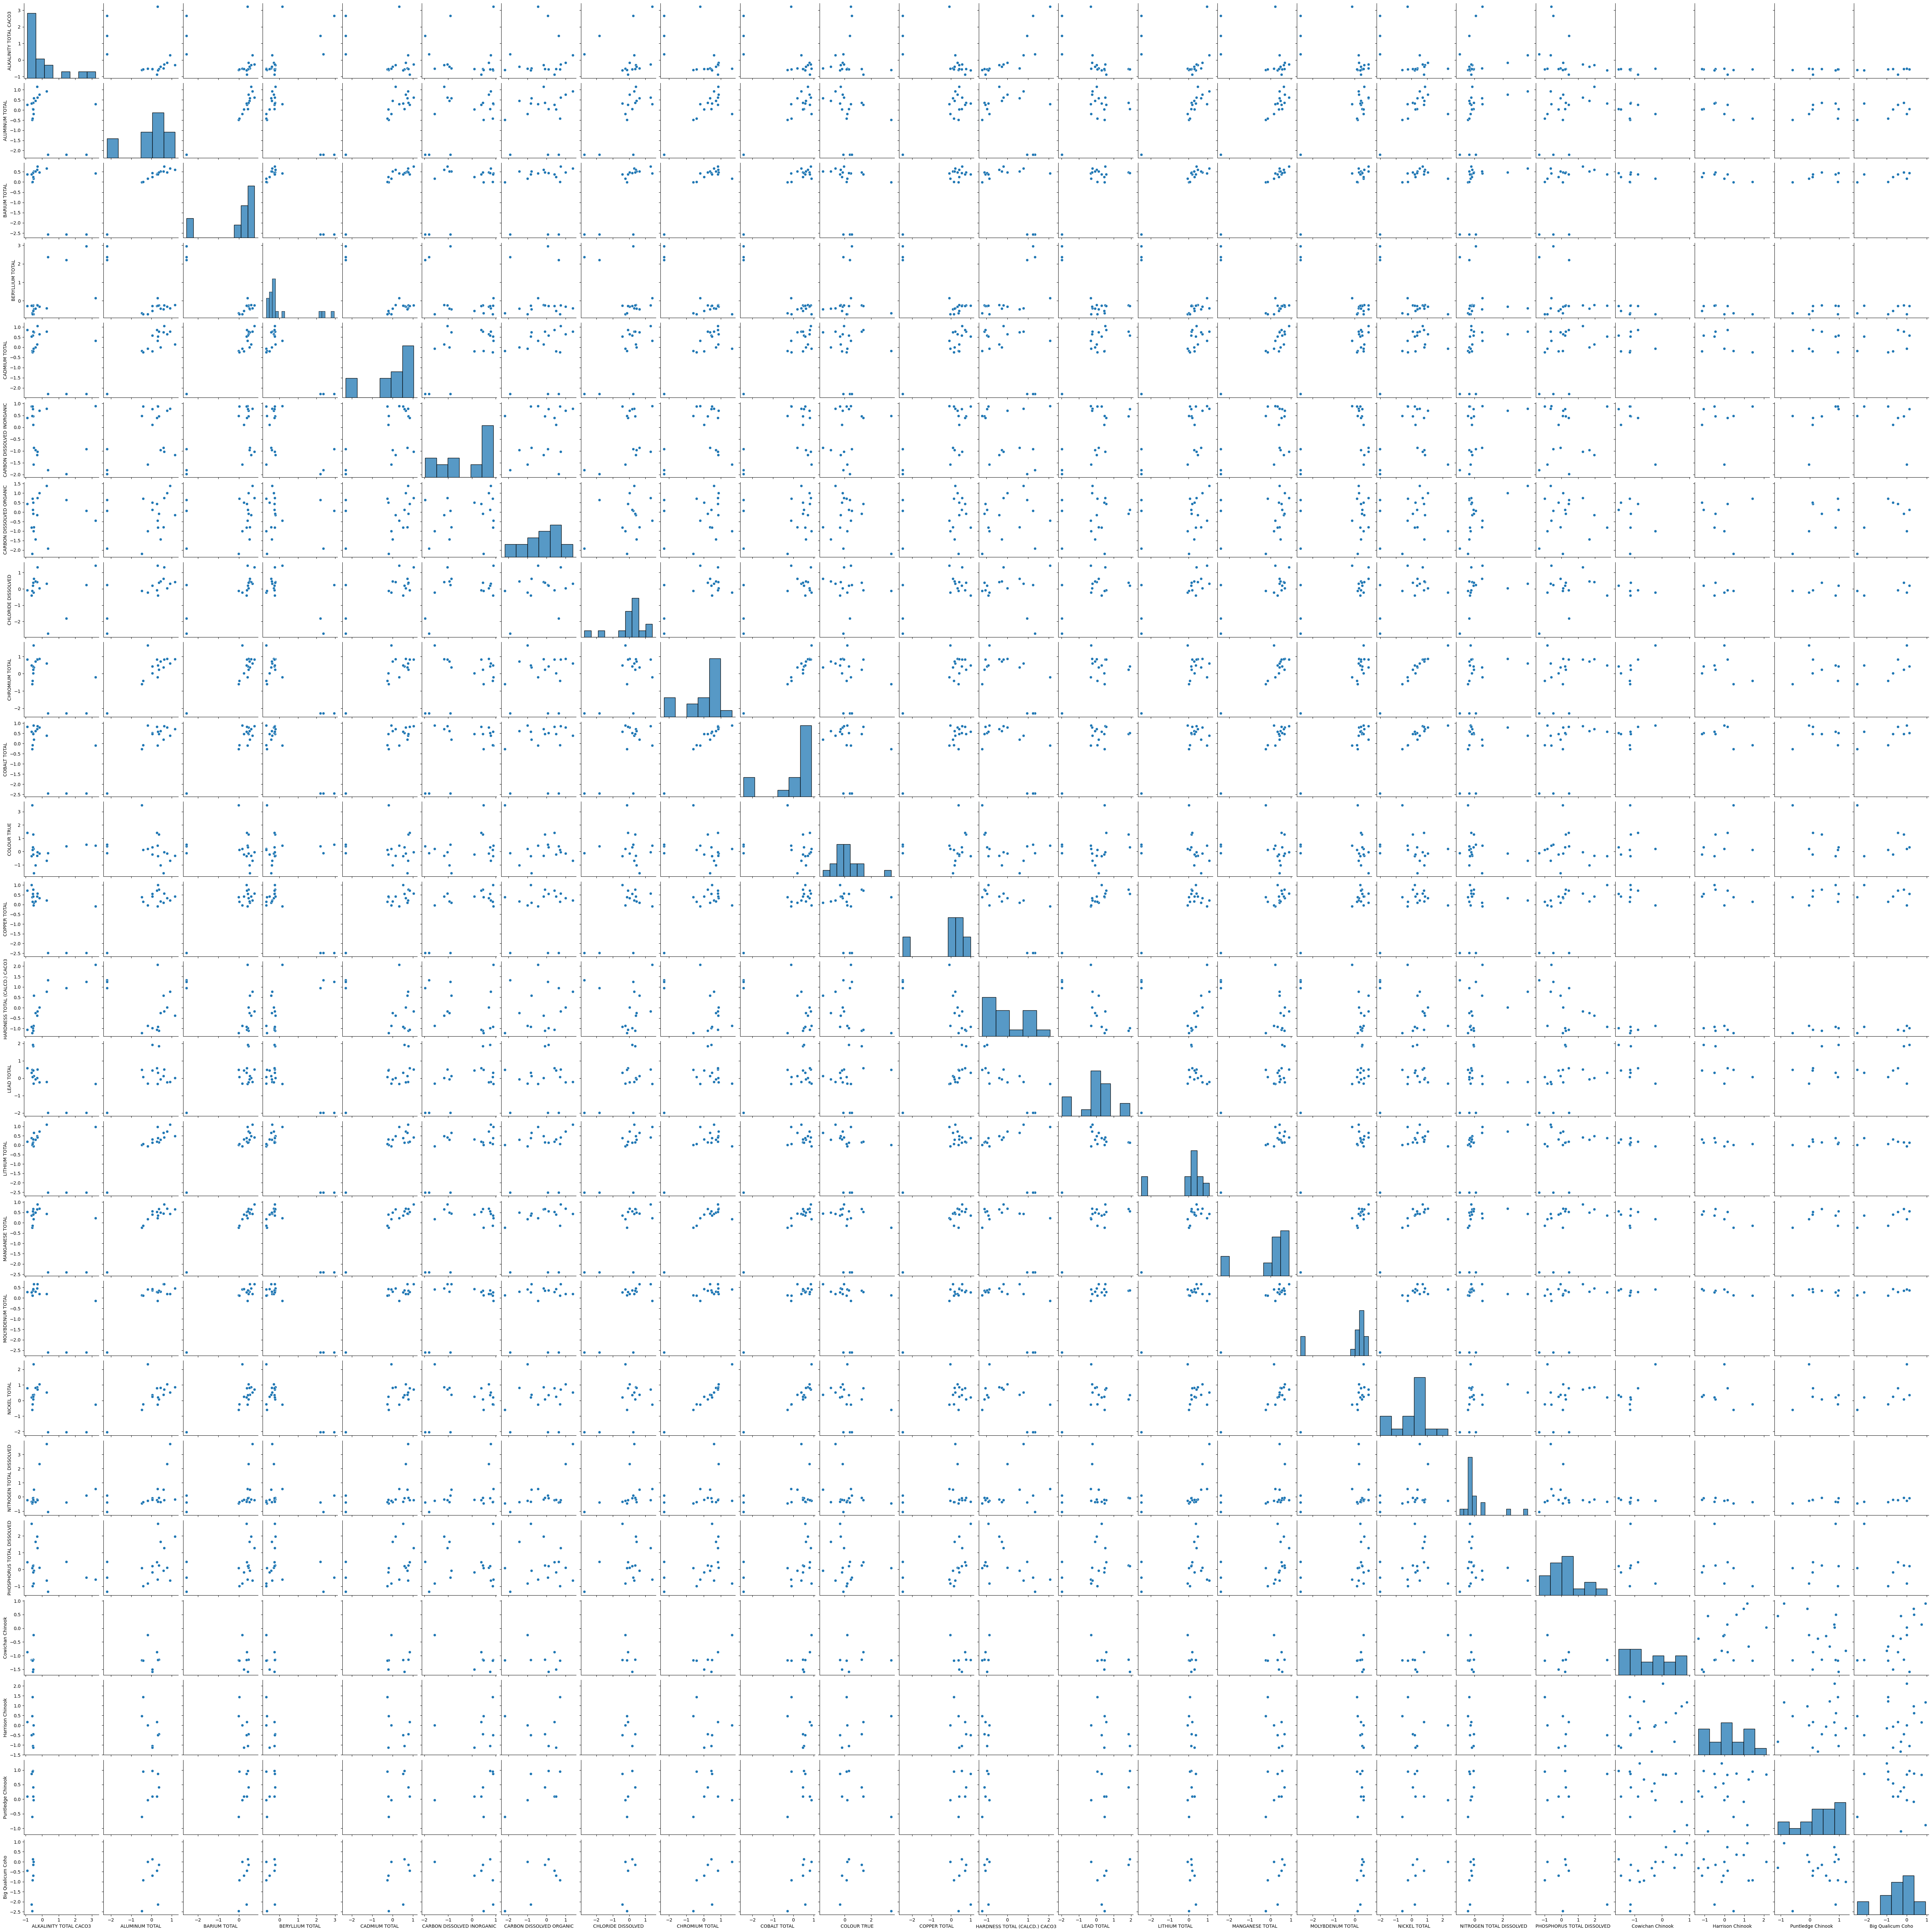

In [8]:
Explore_Fraser_qual_1 = pd.concat([Fraser_qual_nrm_2000.drop(columns=['Time']).iloc[:,0:20],Sal_viab_nrm_2000.drop(columns=['Year'])], axis=1)

sns.pairplot(Explore_Fraser_qual_1[Explore_Fraser_qual_1.columns])

plt.show()

These all look flat!

Out of all of these, we could keep an eye on LEAD TOTAL.

/opt/homebrew/Caskroom/miniforge/base/envs/firstenvironment/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


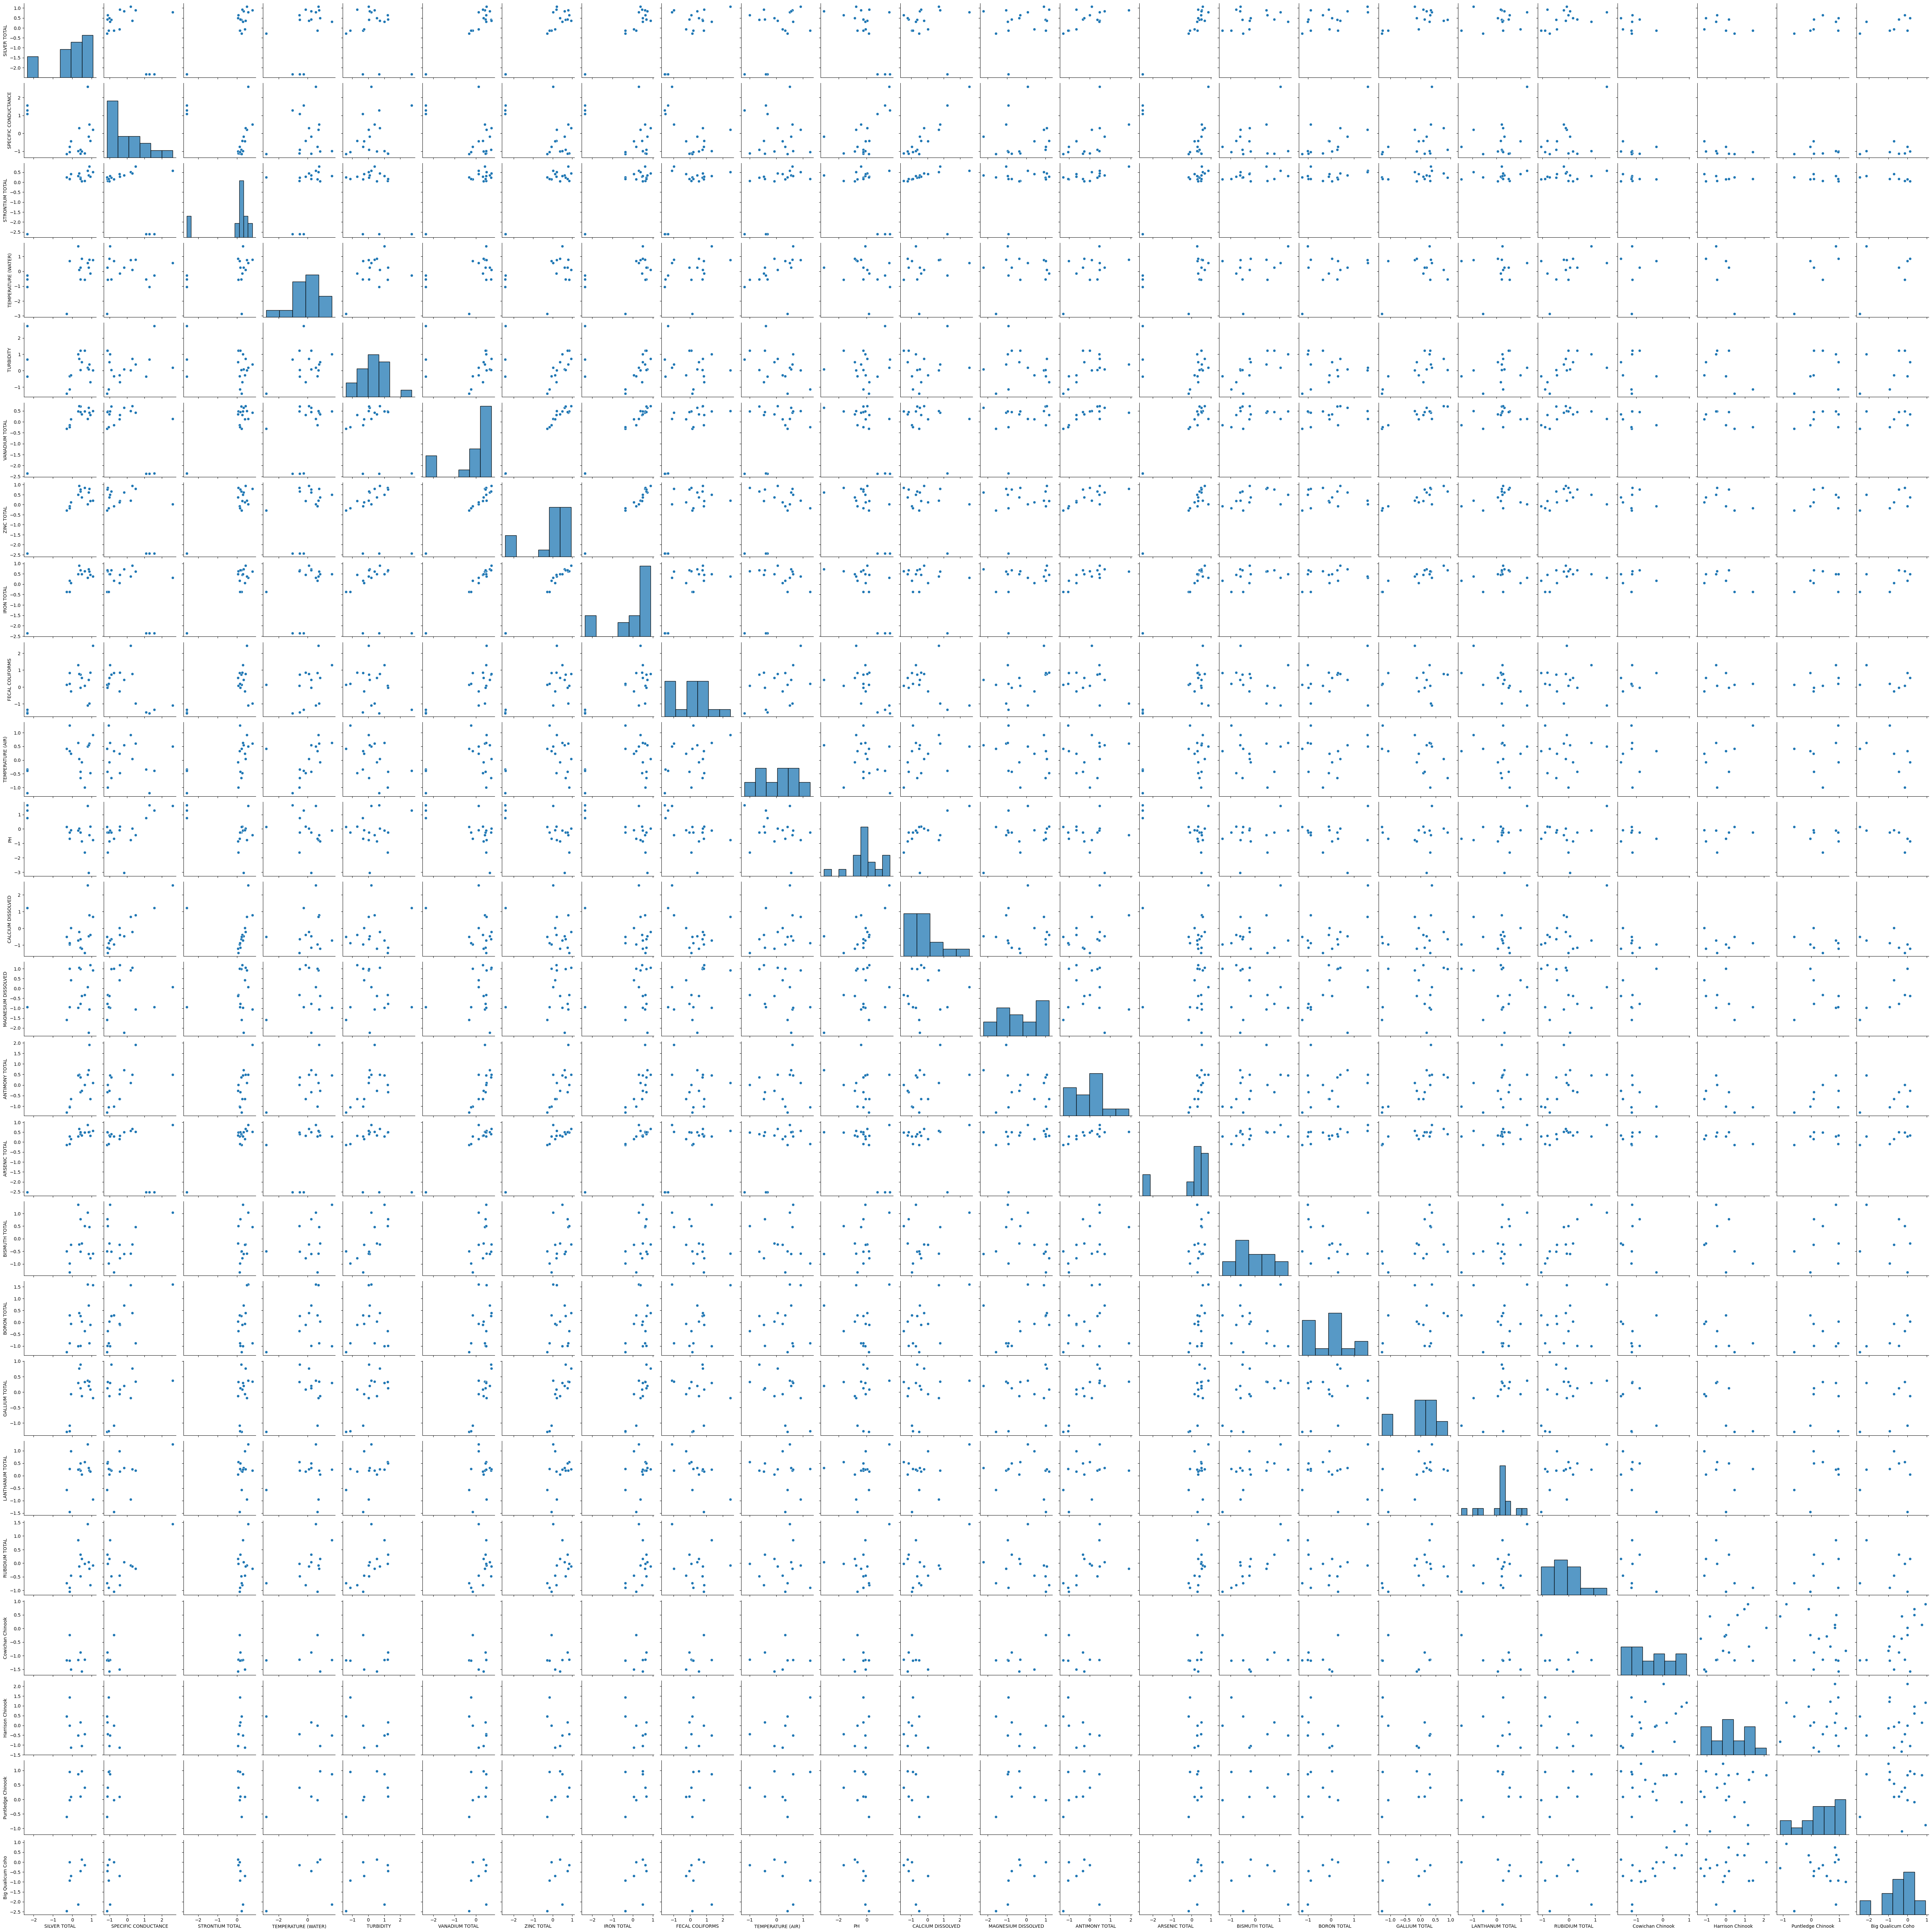

In [9]:
Explore_Fraser_qual_2 = pd.concat([Fraser_qual_nrm_2000.drop(columns=['Time']).iloc[:,20:40],Sal_viab_nrm_2000.drop(columns=['Year'])], axis=1)

sns.pairplot(Explore_Fraser_qual_2[Explore_Fraser_qual_2.columns])

plt.show()

TEMPERATURE (WATER), TURBIDITY, TEMPERATURE (AIR),MAGNESIUM DISSOLVED, and ANTIMONY TOTAL look slightly more interesting here.

But we won't get far with these visual inspections, so let's move on to a different approach.

# Lasso Feature Selection  
## Fraser River Water Quality vs Salmon Viability (years 2000-2017)
(Again, for a train/test split, we can restrict the years as indicated in the above code.)

In [10]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

### Test Run on a Small Subset of Variables
And on a single type of salmon.

In [11]:
# for simplicity, we choose one Salmon Viability variable (i.e. type of salmon)
# 1 = 'Cowichan Chinook'
# 2 = 'Harrison Chinook'
# 3 = 'Puntledge Chinook',
# 4 = 'Big Qualicum Coho'
type_sal = 1

Sal_viab_nrm.columns

Index(['Year', 'Cowichan Chinook', 'Harrison Chinook', 'Puntledge Chinook',
       'Big Qualicum Coho'],
      dtype='object')

In [12]:
alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 5, 10, 50, 100, 1000, 10000]
# use the first few variables as features (excluding Time)
features = Fraser_qual_nrm_2000.columns[1:5]

# coefficients placeholder
coeffs = np.zeros((len(alphas), len(features)))

# I don't need to use StandardScaler because I've already normalized the data features
features_df = Fraser_qual_nrm_2000[features]

# loops through alphas and fit lasso models, recording coefficients
for i in range(len(alphas)):
    # make lasso model object
    lasso = Lasso(alpha=alphas[i], max_iter=1000000) 
    # fit the model
    #lasso.fit(features_df, Sal_viab_nrm_2000.drop(columns=['Year']).interpolate())
    # need to only have one y-variable here, so predicting first type of salmon
    lasso.fit(features_df, Sal_viab_nrm_2000[Sal_viab_nrm_2000.columns[type_sal]]) # fit the model
    coeffs[i,:] = lasso.coef_ # record the coefficients

In [13]:
# check the coefficients (alpha hyperparameters) for these first four variables
pd.DataFrame(coeffs, index=alphas, columns=features)

,ALKALINITY TOTAL CACO3,ALUMINUM TOTAL,BARIUM TOTAL,BERYLLIUM TOTAL
0.000001,-0.296451,-1.603389,1.324643,0.017780
0.000010,-0.296362,-1.602772,1.323650,0.017247
0.000100,-0.295475,-1.596599,1.313721,0.011924
0.001000,-0.293015,-1.559765,1.265184,-0.006269
0.010000,-0.262545,-1.172427,0.737797,-0.219139
0.100000,-0.267533,-0.127927,0.000000,-0.022331
0.250000,-0.113273,-0.000000,-0.000000,-0.000000
0.500000,-0.000000,-0.000000,0.000000,-0.000000
0.750000,-0.000000,-0.000000,0.000000,-0.000000
1.000000,-0.000000,-0.000000,0.000000,-0.000000


For this subset of features, we see that ALKALINITY TOTAL CACO3 is most significant and BARIUM TOTAL is the least.

*Important: Lasso does not fit a model when there are NAN entries.  There was giving me problems below, so the next few lines will simply remove columns with NaN entries.  This still leaves many features to consider.  An alternative approach would be to interpolate values.*

In [14]:
# a column with NaN entries
print(Fraser_qual_nrm_2000.iloc[:,8])

# a NaN entry
np.isnan(Fraser_qual_nrm_2000.iloc[17,8])

0    -1.823538
1    -2.746150
2     0.245541
3     1.426984
4     0.313002
5     0.035063
6     0.626228
7     0.411851
8     0.458752
9     1.321304
10   -0.223225
11    0.372515
12   -0.076555
13    0.196703
14   -0.413089
15   -0.125387
16         NaN
17         NaN
Name: CHLORIDE DISSOLVED, dtype: float64


True

In [15]:
# make a water quality dataframe that drops all the columns with any NaN entries
Fraser_qual_nrm_2000_dropnan = Fraser_qual_nrm_2000

for col in Fraser_qual_nrm_2000.columns:
    # check whether there are any nan entries in the column
    if Fraser_qual_nrm_2000[col].isnull().any():
        # if so, then drop the column
        Fraser_qual_nrm_2000_dropnan = Fraser_qual_nrm_2000_dropnan.drop(columns=[col])

# have a look; this brings us down to 68 features
Fraser_qual_nrm_2000_dropnan.head()

,Time,ALKALINITY TOTAL CACO3,ALUMINUM TOTAL,BARIUM TOTAL,BERYLLIUM TOTAL,CADMIUM TOTAL,CARBON DISSOLVED INORGANIC,CARBON DISSOLVED ORGANIC,CHROMIUM TOTAL,COBALT TOTAL,...,FECAL COLIFORMS,TEMPERATURE (AIR),PH,ARSENIC TOTAL,SELENIUM TOTAL,PHOSPHORUS TOTAL,OXYGEN DISSOLVED,NITROGEN NITRITE,NITROGEN TOTAL,ESCHERICHIA COLI
0,-1.661325,1.465735,-2.197512,-2.562983,2.203255,-2.303142,-1.970406,0.646070,-2.301523,-2.442087,...,-1.496778,-0.340665,0.752915,-2.526383,-2.429528,2.834000,0.325382,0.391135,-0.594300,-0.819288
1,-1.516862,0.343797,-2.197443,-2.563109,2.372198,-2.303112,-1.811566,-1.913736,-2.301879,-2.442339,...,-1.547602,-1.201755,1.638345,-2.526623,-2.429490,0.858548,0.225352,0.015502,-1.011297,-0.963256
2,-1.372399,2.667126,-2.196156,-2.562448,2.950208,-2.303231,-0.914837,0.073636,-2.300627,-2.441073,...,-1.349399,-0.392354,1.296132,-2.526573,-2.429682,0.073192,0.048654,-0.188207,-0.766015,-0.331664
3,-1.227936,3.216285,0.299641,0.423515,0.146618,0.321425,0.901783,-0.452643,-0.194674,-0.100352,...,-1.099883,0.502587,1.606658,0.870034,0.407680,0.008684,-0.237846,0.138099,-1.078017,-1.500579
4,-1.083473,0.280860,0.918867,0.663620,-0.398098,0.771053,0.790900,1.387372,0.604060,0.387974,...,-0.981841,0.601730,-0.410729,0.516157,0.170075,-0.076093,-0.499821,0.248420,-1.091484,1.280129


In [16]:
alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 5, 10, 50, 100, 1000, 10000]

# now we do lasso feature selection on the remaining water quality features
features = Fraser_qual_nrm_2000_dropnan.columns[1:]

# coefficients placeholder
coeffs = np.zeros((len(alphas), len(features)))

# features under consideration
features_df = Fraser_qual_nrm_2000_dropnan[features]

# loop through alphas and fit lasso models, recording coefficients
for i in range(len(alphas)):
    # make lasso model object
    lasso = Lasso(alpha=alphas[i], max_iter=1000000)
    # fit the model
    lasso.fit(features_df, Sal_viab_nrm_2000[Sal_viab_nrm_2000.columns[type_sal]])
    # record the coefficients
    coeffs[i,:] = lasso.coef_

In [17]:
coeffs_df = pd.DataFrame(coeffs, index=alphas, columns=features)
coeffs_df

,ALKALINITY TOTAL CACO3,ALUMINUM TOTAL,BARIUM TOTAL,BERYLLIUM TOTAL,CADMIUM TOTAL,CARBON DISSOLVED INORGANIC,CARBON DISSOLVED ORGANIC,CHROMIUM TOTAL,COBALT TOTAL,COLOUR TRUE,...,FECAL COLIFORMS,TEMPERATURE (AIR),PH,ARSENIC TOTAL,SELENIUM TOTAL,PHOSPHORUS TOTAL,OXYGEN DISSOLVED,NITROGEN NITRITE,NITROGEN TOTAL,ESCHERICHIA COLI
0.000001,-0.225068,-0.185016,0.173196,-0.303013,-0.720870,-0.005352,0.237630,0.336871,0.288249,0.447480,...,0.298292,0.266474,0.016437,-0.117355,0.482152,0.389864,2.886126,0.051086,0.359647,0.393585
0.000010,-0.220198,-0.154373,0.100754,-0.336300,-0.668504,-0.016242,0.232476,0.243838,0.330876,0.427988,...,0.316089,0.234046,0.001422,-0.011771,0.442939,0.345313,2.927573,0.030835,0.363515,0.336394
0.000100,-0.087633,-0.000000,-0.000000,-0.000000,-0.212663,-0.055704,0.099826,-0.127710,0.000000,0.369409,...,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.709277,0.529689,-0.022892,0.525356,0.165595
0.001000,-0.099950,-0.000000,-0.000000,-0.000000,-0.220138,-0.122007,0.133980,-0.104578,0.000000,0.375324,...,0.000000,0.000000,0.000000,-0.000000,0.000000,0.724265,0.146229,-0.005357,0.509287,0.195913
0.010000,-0.078841,-0.488023,-0.000000,-0.000000,-0.159706,-0.027621,0.164230,-0.000000,0.000000,0.262777,...,0.000000,0.000000,-0.008839,-0.000000,0.000000,0.418035,0.000000,-0.134987,0.265185,0.240819
0.100000,-0.098356,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.013590,-0.000000,0.000000,0.115624,...,-0.000000,-0.000000,-0.029653,-0.000000,-0.000000,0.001712,0.000000,-0.167392,0.156958,-0.039950
0.250000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027713,...,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.117564,0.046973,-0.000000
0.500000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000
0.750000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000
1.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000


We can see that COLOUR TRUE is most significant amongst the first ten variables, followed by CARBON DISSOLVED ORGANIC and ALKALINITY TOTAL CACO3.

But the coefficients table is too big to fully inspect visually!

#### The Ranking of Water Quality features' impact on Salmon Viability using Lasso Regression

(For the type of salmon specified at the beginning of the secion, and for water quality features with complete data!)

In [18]:
# create a list of feature scores recording the number of nonzero entries in each column
feature_scores = [(coeffs_df[col].values != 0).sum() for col in coeffs_df.columns]

# the ranking of water quality variables, as a dataframe
pd.DataFrame([feature_scores], columns=features_df.columns).transpose().sort_values(by=0, ascending=False).rename(columns={0:'Feature Score'}).head(30)

,Feature Score
NITROGEN TOTAL,7
NITROGEN NITRITE,7
COLOUR TRUE,7
ALKALINITY TOTAL CACO3,6
CARBON DISSOLVED ORGANIC,6
PHOSPHORUS TOTAL,6
PHOSPHORUS TOTAL DISSOLVED,6
ESCHERICHIA COLI,6
MOLYBDENUM TOTAL,5
CADMIUM TOTAL,5


#### Here we change the lasso loop to cover all four salmon types at once

In [19]:
alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 5, 10, 50, 100, 1000, 10000]

# now we do lasso feature selection on the remaining water quality features
features = Fraser_qual_nrm_2000_dropnan.columns[1:]

# coefficients placeholder
coeffs = np.zeros((len(alphas), len(features)))

# features under consideration
features_df = Fraser_qual_nrm_2000_dropnan[features]

results = []
# loop through salmon types
for type_sal in range(1,5):
    # loop through alphas and fit lasso models, recording coefficients
    for i in range(len(alphas)):
        # make lasso model object
        lasso = Lasso(alpha=alphas[i], max_iter=1000000)
        # fit the model
        lasso.fit(features_df, Sal_viab_nrm_2000[Sal_viab_nrm_2000.columns[type_sal]])
        # record the coefficients
        coeffs[i,:] = lasso.coef_
    coeffs_df = pd.DataFrame(coeffs, index=alphas, columns=features)
    # create a list of feature scores recording the number of nonzero entries in each column
    feature_scores = [(coeffs_df[col].values != 0).sum() for col in coeffs_df.columns]
    # the ranking of water quality variables, as a dataframe
    results = results + [pd.DataFrame([feature_scores], columns=features_df.columns).transpose().sort_values(by=0, ascending=False)]

In [20]:
# the feature ranking results by individual salmon type
results

[                            0
 NITROGEN TOTAL              7
 NITROGEN NITRITE            7
 COLOUR TRUE                 7
 ALKALINITY TOTAL CACO3      6
 CARBON DISSOLVED ORGANIC    6
 PHOSPHORUS TOTAL            6
 PHOSPHORUS TOTAL DISSOLVED  6
 ESCHERICHIA COLI            6
 MOLYBDENUM TOTAL            5
 CADMIUM TOTAL               5
 NITROGEN TOTAL DISSOLVED    5
 TURBIDITY                   5
 CARBON DISSOLVED INORGANIC  5
 CHROMIUM TOTAL              4
 LEAD TOTAL                  4
 OXYGEN DISSOLVED            4
 SPECIFIC CONDUCTANCE        4
 STRONTIUM TOTAL             4
 IRON TOTAL                  4
 PH                          4
 ALUMINUM TOTAL              3
 TEMPERATURE (AIR)           2
 BARIUM TOTAL                2
 BERYLLIUM TOTAL             2
 SELENIUM TOTAL              2
 ARSENIC TOTAL               2
 LITHIUM TOTAL               2
 FECAL COLIFORMS             2
 MANGANESE TOTAL             2
 VANADIUM TOTAL              2
 COBALT TOTAL                2
 SILVER 

In [21]:
# make a list collecting the most significant features for all four salmon types
sig_features_all = []

# let's say a feature is significant if its feature score is greater than a specified value for any salmon type
sig_thresh = 5

for i in range(1,4):
    # the indices are what we want; push these to a new column
    get_features = results[i].reset_index()
    sig_features_all = sig_features_all + get_features.loc[get_features[0] > sig_thresh]['index'].to_list()

sig_features_all = list(set(sig_features_all))
print(len(sig_features_all))
sig_features_all

15


['CHROMIUM TOTAL',
 'SILVER TOTAL',
 'FECAL COLIFORMS',
 'PHOSPHORUS TOTAL DISSOLVED',
 'NITROGEN TOTAL DISSOLVED',
 'CARBON DISSOLVED ORGANIC',
 'PH',
 'CADMIUM TOTAL',
 'COLOUR TRUE',
 'NITROGEN NITRITE',
 'ESCHERICHIA COLI',
 'NICKEL TOTAL',
 'NITROGEN TOTAL',
 'CARBON DISSOLVED INORGANIC',
 'ALKALINITY TOTAL CACO3']

This produces a list of water quality features that are significant predictors of salmon viability over all four salmon types.

Caveats: 
- The date range for water quality measurements does not include the 1990s, so these variables cannot be immediately incorporated into a model with our other variables for the fullest date range.
- Many water quality variables were dropped due to NaN entries.

To see how these water quality features compare with BC and WA regional population data, Port of Vancouver cargo tonnage, and the NPGO climate index over the years 2000-2017, see the file `/Andrew_Explore/Andrew_Explore_Lasso.ipynb`.  In particular, the data suggests that Fraser River water quality measurements should continue to be collected into the future, for its predictive value.